In [1]:
import pandas as pd
import pickle
from tqdm import tqdm

# from openAI import LLM, Sentiment
from roberta import roBERTa, Sentiment

/home/nathan/miniconda3/envs/airline/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First, load data from pickle files into pandas dataframes

In [2]:
llm = roBERTa()
airlines = [
    ('American Airlines','scraped_data/american.pkl'),
    ('Delta Airlines', 'scraped_data/delta.pkl'),
    ('Spirit Airlines', 'scraped_data/spirit.pkl'),
    ('Southwest Airlines', 'scraped_data/southwest.pkl')
]

In [3]:
def convert_to_dataframe(raw_data):

    #ignore pandas warning
    pd.options.mode.chained_assignment = None
    
    #convert to pandas dataframe, with only the columns we need
    df_raw = pd.DataFrame(raw_data)
    df = df_raw[['time', 'text', 'comments', 'comments_full']]
    df['time'] = pd.to_datetime(df['time'])
    df = df.set_index('time')

    #replace comments with just text and commenter name
    df['comments_full'] = df['comments_full'].apply(lambda x: [(comment['commenter_name'], comment['comment_text'].replace('\n', '')) for comment in x])

    return df

In [4]:
data_dict = {}
for airline_name, pickle_file in airlines:
    with open(pickle_file, 'rb') as f:
        raw_data = pickle.load(f)
    data_dict[airline_name] = convert_to_dataframe(raw_data)

In [5]:
data_dict['Spirit Airlines'].head()

,text,comments,comments_full
time,,,
2023-07-21 16:46:39,Introducing the flying sensation that’s turnin...,74,"[(Greene Durham, Spirit Airlines is a great co..."
2023-07-20 19:25:39,Ready for a soaring adventure? 🛫\n\nWayman Avi...,33,"[(Devon McCann, Speaking of soaring, I used to..."
2023-07-14 14:29:18,Where to next? ✈️ Screenshot to find your next...,162,"[(Spirit Airlines, Daniela Soriano We'd like t..."
2023-07-13 12:08:20,The Spirit Charitable Foundation is proud to c...,45,"[(Dalibaso Bhakabha, Very, nice, americe)]"
2023-07-12 15:53:22,Want to #FlyFree in 2023? ✈️\n\nEnter to win f...,72,"[(Jodi Nicole, I just love being able to trave..."


In [6]:
airline_usernames = ['Delta Air Lines', 'Spirit Airlines', 'American Airlines', 'Southwest Airlines']
def classify_all_comments(post, airline_name):
    '''Classify the sentiment of all comments in a post
    '''
    positive = 0
    negative = 0
    neutral = 0

    comments = post['comments_full']
    for commenter_name, comment in comments:
        if commenter_name in airline_usernames:
            continue #ignore comments from the airline itself

        sentiment = llm.classifySentiment(comment)
        if sentiment == Sentiment.POSITIVE:
            positive += 1
        elif sentiment == Sentiment.NEGATIVE:
            negative += 1
        elif sentiment == Sentiment.NEUTRAL:
            neutral += 1
        
    return positive, negative, neutral

def classify_dataframe(df):
    sentiments = []
    for i in tqdm(range(len(df))):
        post = df.iloc[i]
        positive, negative, neutral = classify_all_comments(post, 'Delta Airlines')
        sentiments.append((positive, negative, neutral))
    return sentiments

In [40]:
df = data_dict['Spirit Airlines']
df['sentiments'] = classify_dataframe(df)
df.to_pickle(f'sentiment_data/spirit.pkl')

data_dict['Delta Airlines']

100%|██████████| 400/400 [00:37<00:00, 10.60it/s]


,text,comments,comments_full,sentiments
time,,,,
2023-07-18 14:30:00,What words rhyme with Delta?,2420,"[(Emily Carlton Wagoner, Felta nother trip com...","(35, 2, 23)"
2023-07-13 00:00:00,Delta Air Lines\n\nSharing is caring ❤️️\n\nSe...,303,"[(Tita Yo, We were in Copenhagen last week. Fl...","(26, 22, 12)"
2023-07-12 00:00:00,Delta Air Lines\n\nSilver Medallion Member Law...,8310,"[(Annetta Burke, Brilliant team work), (Jane V...","(60, 0, 0)"
2023-07-11 11:58:57,"When you’re out there seeing the world, the wo...",93,"[(Anita Delta Moncur, I Really Love You Delta ...","(11, 15, 4)"
2023-07-10 12:00:18,"🔐 Unlock more than fast, free Wi-Fi.\n\nGet ex...",210,"[(Thomas Poster, Delta Airlines ! Thanks for e...","(25, 23, 12)"
...,...,...,...,...
2020-05-22 13:57:46,Nothing is more important than the health and ...,1043,"[(Dawn Barrack, I had to fly this past week fr...","(16, 31, 13)"
2020-05-19 00:00:00,Delta Air Lines\n\nYour safety always comes fi...,1948,"[(Walter Bass, Delta Air Lines my husband and ...","(10, 32, 18)"
2020-05-15 00:00:00,Delta Air Lines\n\nThe safety of our customers...,1085,"[(Pat Kaufman, Dear Delta, I was booked for di...","(18, 36, 6)"


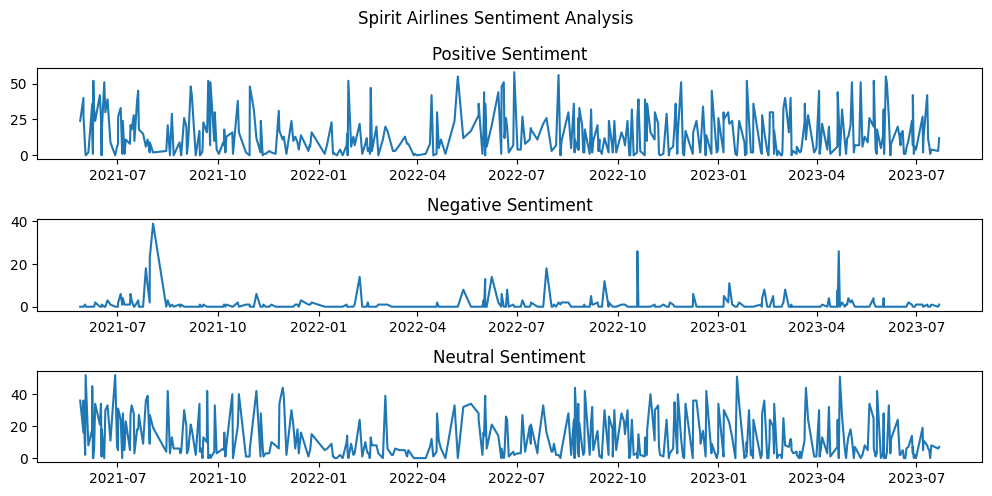

In [38]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3, 1, figsize=(10, 5))

fig.suptitle('Southwest Airlines Sentiment Analysis')

df = pd.read_pickle('sentiment_data/southwest.pkl')

#sort dataframe by date
df = df.sort_index()

positive = [sentiment[0] for sentiment in df['sentiments']]
negative = [sentiment[1] for sentiment in df['sentiments']]
neutral = [sentiment[2] for sentiment in df['sentiments']]

dates = df.index.to_list()

ax[0].plot(dates, positive, label='Positive')
ax[1].plot(dates, negative, label='Negative')
ax[2].plot(dates, neutral, label='Neutral')

ax[0].set_title('Positive Sentiment')
ax[1].set_title('Negative Sentiment')
ax[2].set_title('Neutral Sentiment')

#add spacing between subplots
fig.tight_layout(pad=1.0)

plt.show()